# Initial Data Reading and Cleaning

In [96]:
import pandas as pd
import numpy as np

df = pd.read_csv('./ingredients_refined.csv')

df = df.drop_duplicates(subset=['ingredient'])

ingredients = np.array(df['ingredient'].str.lower().values)
price = np.array(df['price'].values)
metric = np.array(df['metric'].values)

# Building the amount matrix

In [97]:
import json

with open('./augmented_recipes.json', 'r') as f:
    recipes = json.load(f)

matrix = pd.DataFrame(columns=ingredients, index = [recipe['id'] for recipe in recipes])
matrix.columns = matrix.columns.str.strip()

for recipe in recipes:
    for ingredient, quantity in zip(recipe["ingredients"], recipe["quantities"]):
        ingredient = ingredient.strip().lower()
        for column in matrix.columns:
            if ingredient in column:  # Check if ingredient is a substring of the column
                matrix.loc[recipe["id"], column] = quantity

matrix = matrix.fillna(0)
matrix.to_csv('./matrix.csv')

# Modeling

# TO ADD

1. Advanced recipes constraint (i.e.) $$ \sum_{i=1}^{|I|} Contains_{i. r}*x_r \geq 7 \ \ \forall r$$
2. Add the amount (normal distribution)
    - Have to create 2 matrices now, 1 for amount and 1 for contains

### Set definitions

In [98]:
import gamspy as gp
import numpy as np
import gamspy.math as gpm

cont = gp.Container()
I = cont.addSet('I', records = [ingredients[idx] for idx in range(len(ingredients))], description = 'A set containing all of the valid ingredients')
R = cont.addSet('R', records = [recipe['id'] for recipe in recipes], description= 'A set containing all of the recipes that can be made')
S = cont.addSet('S', records = [1/15, 1/10, 1/5, 1/4, 1/2, 1], description="Sizes of ingredients purchasable")

### Parameter Definitions

In [99]:
PPS = cont.addParameter('PPS', domain=[S], description="Price per size scalar",
                        records=np.array([[1/15], [1/10], [1/5], [1/4], [1/2], [1]]))
APS = cont.addParameter('PPS', domain=[S], description="Unit amount per size scalar",
                        records=np.array([[1/15], [1/10], [1/5], [1/4], [1/2], [1]]))

C = cont.addParameter('C', domain=[S, I], description="Cost per unit of each of the ingredients",
                      records = np.expand_dims(PPS.records['value'].to_numpy(), axis=0).T * np.tile(price, (6,1)))

A = cont.addParameter('A', domain=[R, I], description="Amount of ingredient i required in recipe r", records = np.array(matrix))
B = cont.addParameter('B', description="Budget to purchase ingredients", records=400)
lam = cont.addParameter('lam', description="Trade off parameter used to weight the regularizer", records = .01)

### Variable Definitions

In [100]:
z = cont.addVariable('z', "integer", domain=[S, I], description="Amount of ingredient i purchased")
x = cont.addVariable('x', "binary", domain=[R], description="Indicator variable to make recipe r")
l = cont.addVariable('l', "free", domain=[I], description="Leftover ingredients after all recipes are made")

### Equations

In [101]:
budget = cont.addEquation('budget', 'regular',
                        description="Constrains the total money spent on ingredients to be within the budget")
budget[:] = gp.Sum([S,I], C[S,I] * z[S,I]) <= B

ingredient_amounts = cont.addEquation('ingredient_amounts', 'regular', domain=[I],
                              description="Ensures enough ingredients are purchased to satisfy the selected recipes")
ingredient_amounts[I] = gp.Sum(R, A[R, I] * x[R]) <= gp.Sum(S, APS[S] * z[S, I])

waste = cont.addEquation('waste', 'regular', domain=[I],
                          description="Sets the leftover variable equal to the amount of unused ingredients")
waste[I] = l[I] == gp.Sum(S, APS[S] * z[S, I]) -  gp.Sum(R, A[R, I] * x[R])

tot_recipes = cont.addEquation('tot_recipes', description="Ensures enough recipes for a weeks worth of dinner can be made")
tot_recipes[:] = gp.Sum(R, x[R]) >= 7

z.lo[S, I]= 0
l.lo[:] = 0

In [102]:
objective = gp.Sum(R, x[R]) - lam * gp.Sum(I, l[I])

recipe_optimization = cont.addModel(
    name='recipe_optimization',
    problem=gp.Problem.MIP,
    equations=cont.getEquations(),
    sense=gp.Sense.MAX,
    objective=objective
)

In [103]:
recipe_optimization.solve(solver = 'cplex')
df = z.records
print(f"Amount of ingredients to purchase: {len(df[df['level'] > 0])}")
print(f"Recipes to make {x.records[x.records['level'] > 0]}")

Amount of ingredients to purchase: 149
Recipes to make          R  level  marginal  lower  upper  scale
1    25693    1.0    1.0229    0.0    1.0    1.0
11   49136    1.0    1.0265    0.0    1.0    1.0
13   31318    1.0    1.0198    0.0    1.0    1.0
14   31027    1.0    1.0118    0.0    1.0    1.0
17   19757    1.0    1.0377    0.0    1.0    1.0
..     ...    ...       ...    ...    ...    ...
117  25118    1.0    1.0045    0.0    1.0    1.0
118  17586    1.0    1.0045    0.0    1.0    1.0
119  22678    1.0    1.0147    0.0    1.0    1.0
120    428    1.0    1.0045    0.0    1.0    1.0
123  20983    1.0    1.0351    0.0    1.0    1.0

[70 rows x 6 columns]


# Sensitivity Analysis

## lambda sensitivity

## budget sensitivity

In [104]:
import seaborn as sns
import matplotlib.pyplot as plt 

amount_recipes = []
budget = []
loss = []

for num in range(100, 1000):
    B.setRecords(num)
    recipe_optimization.solve(solver = 'cplex')
    df = x.records
    number_recipes = len(df[df['level'] > 0])
    loss.append(l.records['level'].sum())
    budget.append(num)
    amount_recipes.append(number_recipes)
    num += 50

import seaborn as sns

sns.lineplot(x = budget, y = amount_recipes)
plt.grid()


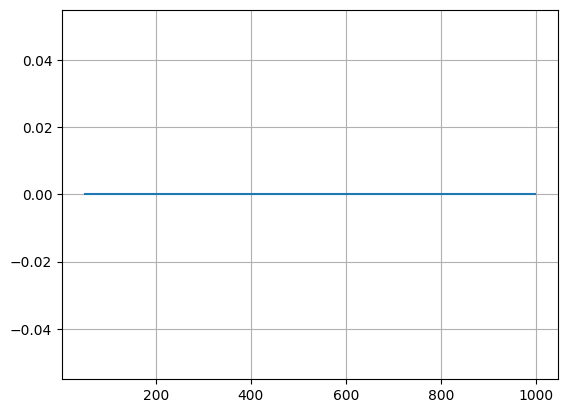

In [ ]:
sns.lineplot(x = budget, y = loss)
plt.grid()